In [ ]:
import numpy as np
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout,Flatten, Input, SimpleRNN, BatchNormalization
from tensorflow.keras import Sequential 
#from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import train_test_split

In [ ]:
ds = pd.read_csv("/content/drive/MyDrive/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")

In [ ]:
ds["Date"] = pd.to_datetime(ds["Timestamp"],unit="s").dt.date
data=ds.groupby("Date").mean()
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Date,,,,,,,,
2011-12-31,1325346930,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,1325419170,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,1325505570,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,1325591970,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,1325678370,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159


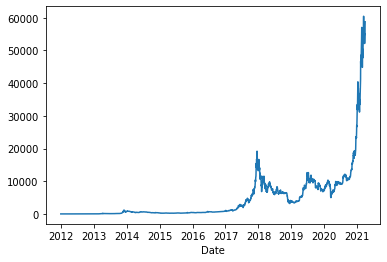

In [ ]:
price_by_date=data["Weighted_Price"].rename("USD Price")
price_by_date.plot()

In [ ]:
######## Prepare timesteps groups ########
def create_data(time_window, price_by_date):
  
  time_ahead = 1 # Short forecast
  scaler=MinMaxScaler()
  length = len(price_by_date)
  price_scaled=scaler.fit_transform(pd.DataFrame(price_by_date))[:,-1]
  price_groups = []
  for i in range(0,length-time_window):
      price_groups.append(price_scaled[i:i+time_window])

  price_groups = np.array(price_groups)
  price_groups=price_groups[...,np.newaxis]
  return price_groups,scaler

In [ ]:
def split_data(price_groups, split_rate):
  time_ahead = 1
  length = len(price_groups)
  X_train = price_groups[:int(length*(split_rate)), :-time_ahead]
  X_test =  price_groups[int(length*(split_rate)):, :-time_ahead]
  y_train = price_groups[:int(length*(split_rate)),  -time_ahead:]
  y_test =  price_groups[int(length*(split_rate)):,  -time_ahead:]
  print(X_train.shape,y_train.shape)
  print(X_test.shape,y_test.shape)

  return X_train, y_train, X_test, y_test

In [ ]:
def create_model(architecture, X_train):

  if architecture == 'simple rnn':
    model = Sequential()
    
    # add input layer
    model.add(Input((None,1)))
    
    # add rnn layer
    model.add(SimpleRNN(10, activation = 'tanh', return_sequences = False))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    # add output layer
    model.add(Dense(1, activation = 'linear'))

  elif architecture == 'complex rnn':
    
    model=Sequential()
    
    #first RNN layer
    model.add(SimpleRNN(128,activation='tanh',return_sequences=True, input_shape=(X_train.shape[1],1)))
    model.add(Dropout(0.25))
    #second RNN layer
    model.add(SimpleRNN(256,activation='tanh',return_sequences=True))
    model.add(Dropout(0.25))
    #third RNN layer
    model.add(SimpleRNN(512,activation='tanh',return_sequences=True))
    model.add(Dropout(0.35))
    #fourth RNN layer
    model.add(SimpleRNN(256,activation='tanh',return_sequences=True))
    model.add(Dropout(0.25))
    #fifth RNN layer
    model.add(SimpleRNN(128,activation='tanh',return_sequences=True))
    model.add(Dropout(0.25))
    #convert the matrix to 1-line
    # model.add(Flatten(None,1))
    #output layer
    model.add(Flatten())
    model.add(Dense(1, activation = 'linear'))
        
  elif architecture == 'lstm1':
    model = keras.models.Sequential([
     keras.layers.LSTM(128,activation='relu', return_sequences=True, input_shape=(None,1)),
     keras.layers.LSTM(128,activation='relu'),
     keras.layers.Dense(1, activation = 'linear')
     ])
  
  else :
    model = Sequential()
    
    # add input layer
    model.add(Input(shape = (None,1)))
    
    # add rnn layer
    model.add(LSTM(200, activation = 'tanh', return_sequences = False))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    # add output layer
    model.add(Dense(1, activation = 'linear'))

  model.summary()

  return model

In [ ]:
def compile_model (model):
  Learning_rate = 0.0001
  optimizer = Adam(lr=Learning_rate)
  # learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
  #                                           patience=3, 
  #                                           verbose=1, 
  #                                           factor=0.5, 
  #                                           min_lr=0.00000000000000000000000000000000000000000005)
  model.compile(optimizer=optimizer, loss="mean_squared_error",  metrics=['mse'])
  return model

In [ ]:
t= forecast_bitcoin(20, price_by_date, 'simple rnn', 0.001, 0.9, '/content/drive/MyDrive/RNN/bert/20', '/content/drive/MyDrive/RNN/bert/20/history.np', 10)

In [ ]:

def main(timeseries, n_epochs, model_type, model_path, history_path, price_by_date):

      price_groups, scaler = create_data(timeseries+1, price_by_date)
      # split train & test features and labels data
      X_train, y_train, X_test, y_test = split_data(price_groups, 0.90)
      X_test, y_test, X_valid, y_valid = X_test[int(len(X_test)/2):],y_test[int(len(X_test)/2):], X_test[:int(len(X_test)/2)], y_test[:int(len(X_test)/2)] 

      model = create_model(model_type, X_train)
      model = compile_model(model)

      history = model.fit(X_train, y_train, epochs = n_epochs, validation_data=(X_valid, y_valid), batch_size = 64)
      model.save(model_path) # saving the model

      np.save(history_path,history.history)

      history = np.load(history_path,allow_pickle=True).item()
      plt.figure(1)
      plt.plot(history['loss'])
      plt.plot(history['val_loss'])
      plt.title('Model Complexity Graph:  Training vs. Validation Loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'validate'], loc='upper right')
      plt.show()

      predicted_data=model.predict(X_test)
      predicted_data=scaler.inverse_transform(predicted_data)
      data_test = scaler.inverse_transform(y_test.reshape(len(y_test),1))

      # if model_type == 'complex rnn':
        
      #     predicted_data = predicted_data.reshape(len(y_test),1)
          



      plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
      plt.plot(data_test,color="r",label="true result")
      plt.plot(predicted_data,color="b",label="predicted result")
      plt.legend()
      plt.xlabel("Time(days)")
      plt.ylabel("Close Values")
      plt.grid(True)
      plt.show()

      pred = []
      ## predict first 10 days that is influenced by last X_test data
      pr = model.predict(X_test[-1,:,:].reshape(1,timeseries,1))
      t = np.array(X_test[-1,:,:])
      pred.append(pr)


      for i in range(1,10):
          t = np.delete(t,0)
          t = np.append(t,pr)
          # print(t)
          pr = model.predict(t.reshape(1,timeseries,1))
          pred.append(pr)


      pred = np.array(pred).reshape(10,1)
      pred = scaler.inverse_transform(pred)

      plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
      plt.plot(data_test,color="r",label="true result")
      plt.plot(predicted_data,color="b",label="predicted test result")
      plt.plot(range(len(predicted_data),len(predicted_data)+len(pred)),pred,color="g",label = "predicted future")
      plt.legend()
      plt.xlabel("Time(days)")
      plt.ylabel("Close Values")
      plt.grid(True)
      plt.show()

      plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
      plt.plot(scaler.inverse_transform(y_train.reshape(len(y_train), 1)),color="y",label="train & valid data")
      plt.plot(range(len(y_train),len(y_train)+len(y_valid)), scaler.inverse_transform(y_valid.reshape(len(y_valid), 1)),color="y")
      plt.plot(range(len(y_train)+len(y_valid),len(y_train)+len(y_valid)+len(data_test)),data_test,color="r",label="true result")
      plt.plot(range(len(y_train)+len(y_valid),len(y_train)+len(y_valid)+len(data_test)),predicted_data,color="b",label="predicted test result")
      plt.plot(range(len(y_train)+len(y_valid)+len(data_test),len(y_train)+len(y_valid)+len(data_test)+len(pred)),pred,color="g",label = "predicted future")
      plt.legend()
      plt.xlabel("Time(days)")
      plt.ylabel("Close Values")
      plt.grid(True)
      plt.show()

Simple RNN 20

(3019, 20, 1) (3019, 1, 1)
(336, 20, 1) (336, 1, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                120       
_________________________________________________________________
batch_normalization (BatchNo (None, 10)                40        
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 171
Trainable params: 151
Non-trainable params: 20
_________________________________________________________________
Epoch 1/100
95/95 [==============================] - 2s 9ms/step - loss: 0.2903 - mse: 0.2903 - val_loss: 0.0495 - val_mse: 0.0495
Epoch 2/100
95/95 [==============================] - 0s 5ms/step - loss:

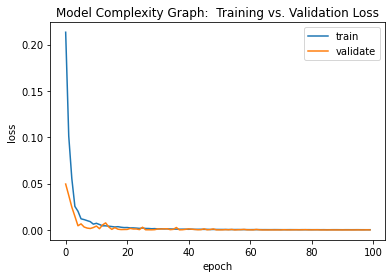

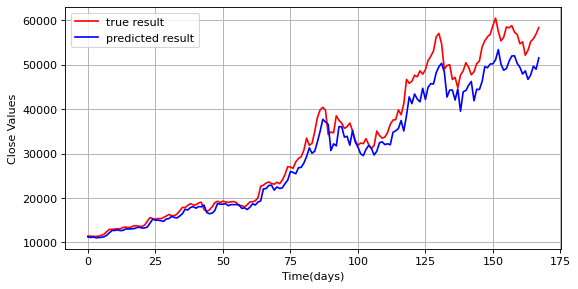

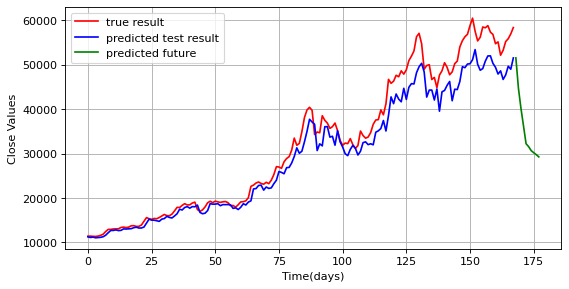

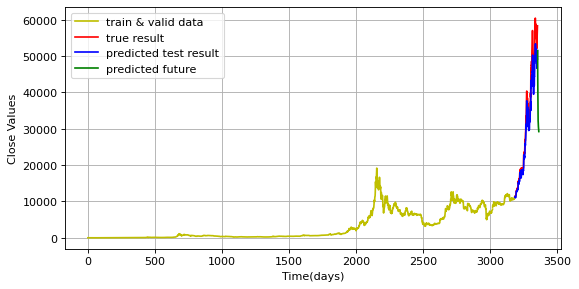

In [ ]:
main(20, 100, 'simple rnn', model_path = "/content/drive/MyDrive/RNN/simple_RNN/30",
         history_path = "/content/drive/MyDrive/RNN/simple_RNN/30/history.npy", price_by_date = price_by_date)

Simple RNN 30

(3010, 30, 1) (3010, 1, 1)
(335, 30, 1) (335, 1, 1)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_64 (SimpleRNN)    (None, 10)                120       
_________________________________________________________________
batch_normalization (BatchNo (None, 10)                40        
_________________________________________________________________
dropout_60 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 171
Trainable params: 151
Non-trainable params: 20
_________________________________________________________________
Epoch 1/100
95/95 [==============================] - 3s 22ms/step - loss: 1.7940 - mse: 1.7940 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 2/100
95/95 [==============================] - 2s 19ms/step - 

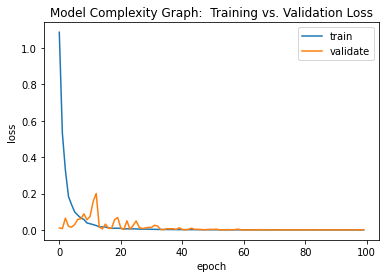

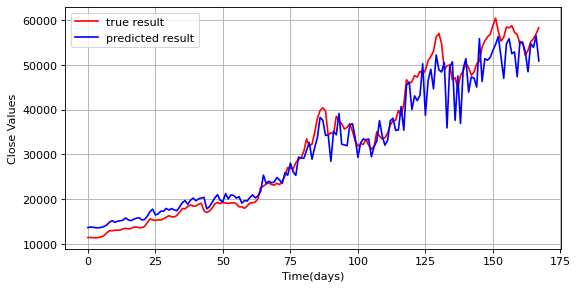

[0.78802337 0.80416445 0.83414152 0.81708325 0.78928234 0.80009928
 0.83064728 0.84024402 0.8928894  0.91595779 0.93079995 0.93996371
 0.97265175 1.         0.95123182 0.91536953 0.92890455 0.96718482
 0.96406547 0.97227405 0.94800384 0.93931175 0.9048418  0.91179954
 0.86213479 0.88065134 0.91294697 0.92352737 0.94141005 0.84166878]
[0.80416445 0.83414152 0.81708325 0.78928234 0.80009928 0.83064728
 0.84024402 0.8928894  0.91595779 0.93079995 0.93996371 0.97265175
 1.         0.95123182 0.91536953 0.92890455 0.96718482 0.96406547
 0.97227405 0.94800384 0.93931175 0.9048418  0.91179954 0.86213479
 0.88065134 0.91294697 0.92352737 0.94141005 0.84166878 0.71001953]
[0.83414152 0.81708325 0.78928234 0.80009928 0.83064728 0.84024402
 0.8928894  0.91595779 0.93079995 0.93996371 0.97265175 1.
 0.95123182 0.91536953 0.92890455 0.96718482 0.96406547 0.97227405
 0.94800384 0.93931175 0.9048418  0.91179954 0.86213479 0.88065134
 0.91294697 0.92352737 0.94141005 0.84166878 0.71001953 0.61290562]


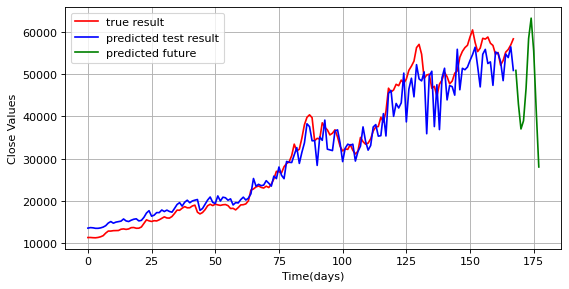

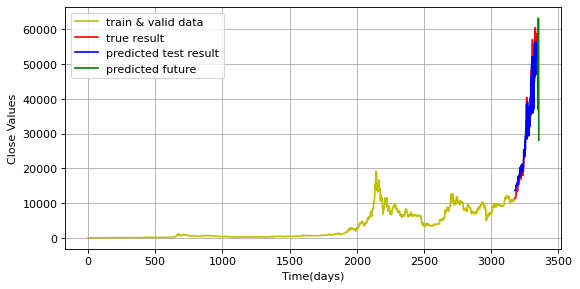

In [ ]:
main(30, 100, 'simple rnn', model_path = "/content/drive/MyDrive/RNN/simple_RNN/30",
         history_path = "/content/drive/MyDrive/RNN/simple_RNN/30/history.npy")

Simple RNN *50*

(2992, 50, 1) (2992, 1, 1)
(333, 50, 1) (333, 1, 1)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
batch_normalization_7 (Batch (None, 10)                40        
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 171
Trainable params: 151
Non-trainable params: 20
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 4s 34ms/step - loss: 0.5255 - mse: 0.5255 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 2/100
94/94 [==============================] - 3s 31ms/step - l

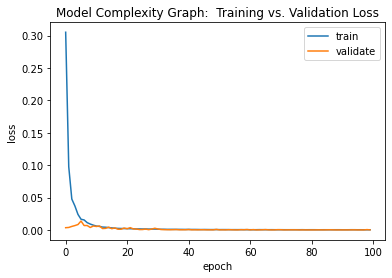

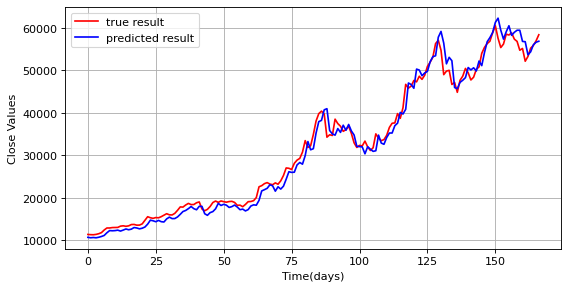

[0.77219174 0.75753938 0.76537181 0.78739276 0.78194103 0.80388657
 0.7916769  0.80793402 0.8421558  0.858357   0.87805159 0.9307783
 0.94350813 0.90492326 0.80997983 0.82373378 0.82679325 0.77171912
 0.77956488 0.74132331 0.78802337 0.80416445 0.83414152 0.81708325
 0.78928234 0.80009928 0.83064728 0.84024402 0.8928894  0.91595779
 0.93079995 0.93996371 0.97265175 1.         0.95123182 0.91536953
 0.92890455 0.96718482 0.96406547 0.97227405 0.94800384 0.93931175
 0.9048418  0.91179954 0.86213479 0.88065134 0.91294697 0.92352737
 0.94141005 0.93989766]
[0.75753938 0.76537181 0.78739276 0.78194103 0.80388657 0.7916769
 0.80793402 0.8421558  0.858357   0.87805159 0.9307783  0.94350813
 0.90492326 0.80997983 0.82373378 0.82679325 0.77171912 0.77956488
 0.74132331 0.78802337 0.80416445 0.83414152 0.81708325 0.78928234
 0.80009928 0.83064728 0.84024402 0.8928894  0.91595779 0.93079995
 0.93996371 0.97265175 1.         0.95123182 0.91536953 0.92890455
 0.96718482 0.96406547 0.97227405 0.9480

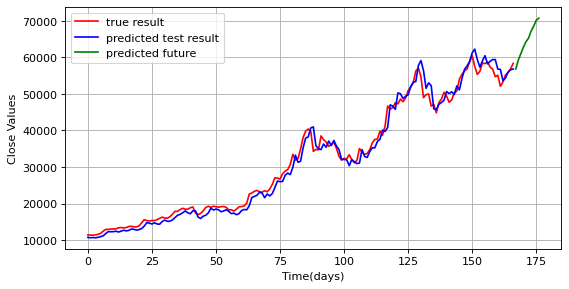

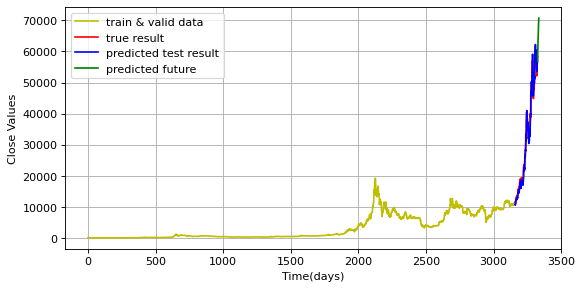

In [ ]:
main(50, 100, 'simple rnn', model_path = "/content/drive/MyDrive/RNN/simple_RNN/50",
         history_path = "/content/drive/MyDrive/RNN/simple_RNN/50/history.npy", price_by_date = price_by_date)

Complex RNN 20

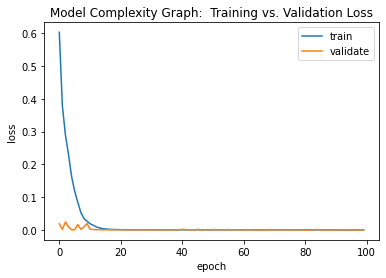

(3019, 20, 1) (3019, 1, 1)
(336, 20, 1) (336, 1, 1)


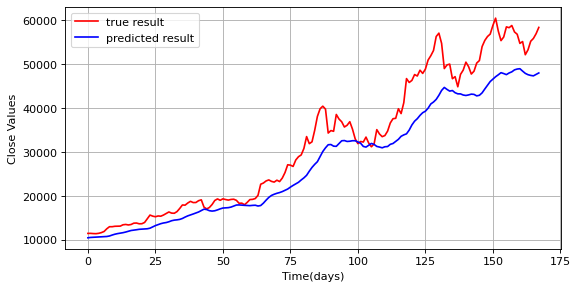

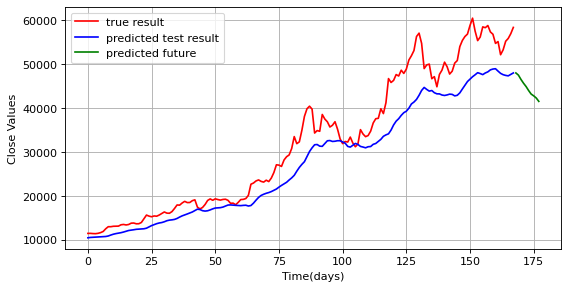

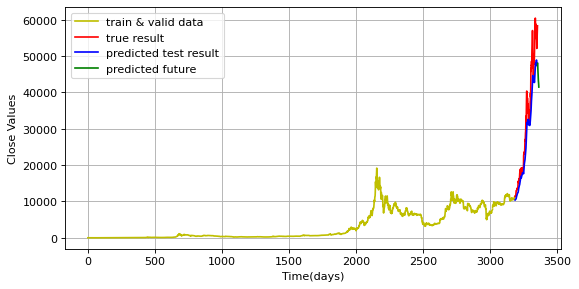

In [ ]:
history = np.load('/content/drive/MyDrive/RNN/complex_RNN/20/history.npy',allow_pickle=True).item()
plt.figure(1)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Complexity Graph:  Training vs. Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

price_groups, scaler = create_data(20+1)
# split train & test features and labels data
X_train, y_train, X_test, y_test = split_data(price_groups, 0.90)
X_test, y_test, X_valid, y_valid = X_test[int(len(X_test)/2):],y_test[int(len(X_test)/2):], X_test[:int(len(X_test)/2)], y_test[:int(len(X_test)/2)] 
model =  keras.models.load_model('/content/drive/MyDrive/RNN/complex_RNN/20')

predicted_data=model.predict(X_test)
predicted_data=scaler.inverse_transform(predicted_data)
data_test = scaler.inverse_transform(y_test.reshape(len(y_test),1))

plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()
timeseries = 20
pred = []
## predict first 10 days that is influenced by last X_test data
pr = model.predict(X_test[-1,:,:].reshape(1,timeseries,1))
t = np.array(X_test[-1,:,:])
pred.append(pr)


for i in range(1,10):
    t = np.delete(t,0)
    t = np.append(t,pr)
    # print(t)
    pr = model.predict(t.reshape(1,timeseries,1))
    pred.append(pr)


pred = np.array(pred).reshape(10,1)
pred = scaler.inverse_transform(pred)

plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted test result")
plt.plot(range(len(predicted_data),len(predicted_data)+len(pred)),pred,color="g",label = "predicted future")
plt.legend()
plt.xlabel("Time(days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(scaler.inverse_transform(y_train.reshape(len(y_train), 1)),color="y",label="train & valid data")
plt.plot(range(len(y_train),len(y_train)+len(y_valid)), scaler.inverse_transform(y_valid.reshape(len(y_valid), 1)),color="y")
plt.plot(range(len(y_train)+len(y_valid),len(y_train)+len(y_valid)+len(data_test)),data_test,color="r",label="true result")
plt.plot(range(len(y_train)+len(y_valid),len(y_train)+len(y_valid)+len(data_test)),predicted_data,color="b",label="predicted test result")
plt.plot(range(len(y_train)+len(y_valid)+len(data_test),len(y_train)+len(y_valid)+len(data_test)+len(pred)),pred,color="g",label = "predicted future")
plt.legend()
plt.xlabel("Time(days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

Complex RNN 30

(3010, 30, 1) (3010, 1, 1)
(335, 30, 1) (335, 1, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 30, 128)           16640     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 30, 256)           98560     
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 30, 512)           393728    
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 512)           0         
_________________________________________________________________
si

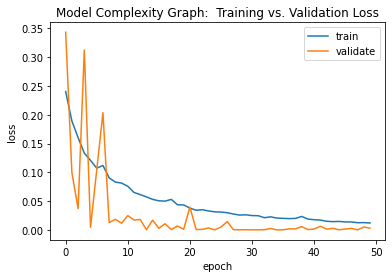

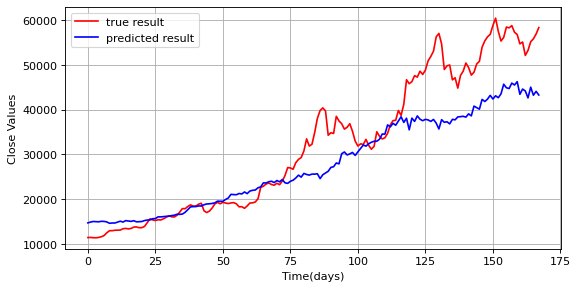

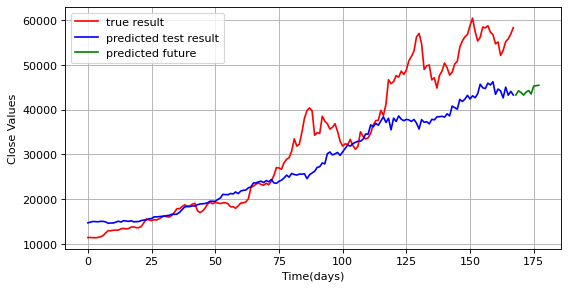

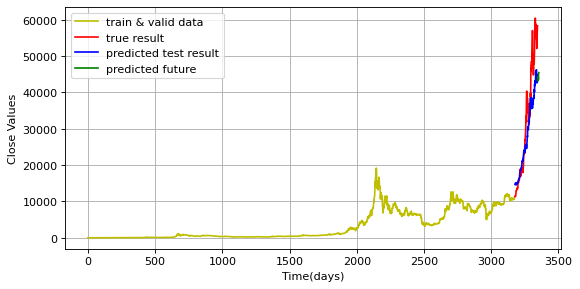

In [ ]:
main(30, 50, 'complex rnn', model_path = "/content/drive/MyDrive/RNN/complex_RNN/30",
         history_path = "/content/drive/MyDrive/RNN/complex_RNN/30/history.npy", , price_by_date = price_by_date)

Complex RNN 50

(2992, 50, 1) (2992, 1, 1)
(333, 50, 1) (333, 1, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50, 128)           16640     
_________________________________________________________________
dropout (Dropout)            (None, 50, 128)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50, 256)           98560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 50, 512)           393728    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 512)           0         
_________________________________________________________________
simp

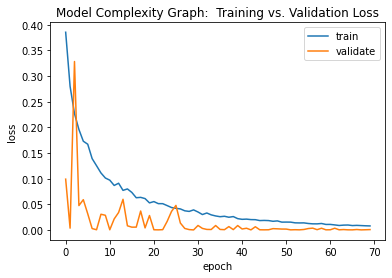

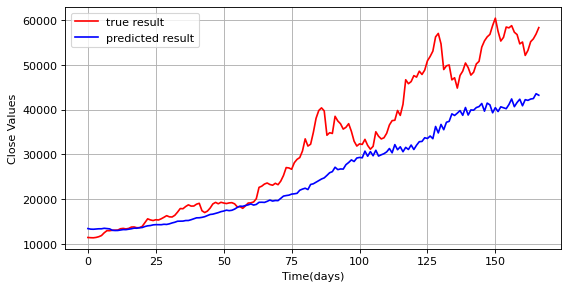

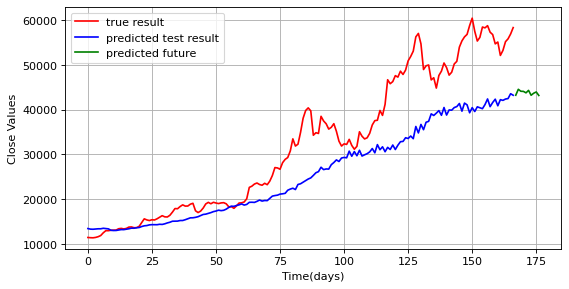

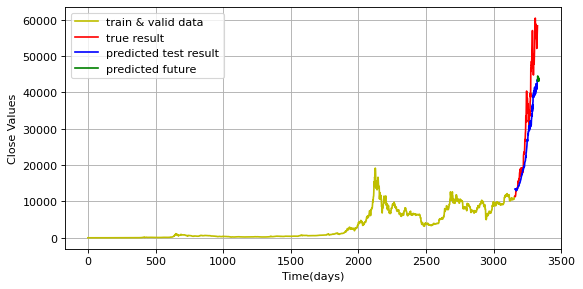

In [ ]:
main(50, 70, 'complex rnn', model_path = "/content/drive/MyDrive/RNN/complex_RNN/50",
         history_path = "/content/drive/MyDrive/RNN/complex_RNN/50/history.npy",  price_by_date = price_by_date)

LSTM1 20

(3019, 20, 1) (3019, 1, 1)
(336, 20, 1) (336, 1, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
95/95 [==============================] - 7s 47ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 3.2394e-04 - val_mse: 3.2394e-04
Epoch 2/100
95/95 [==============================] - 4s 42ms/step - loss: 8.0324e-05 - mse: 8.0324e-05 - val_loss: 8.3513e-05 - val_mse: 8.3513e-05
Epoch 3/100
95/95 [=====================

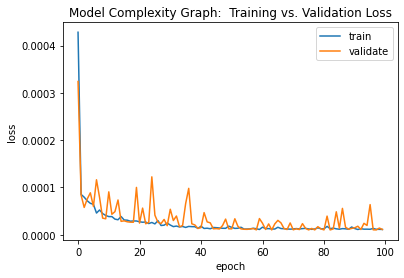

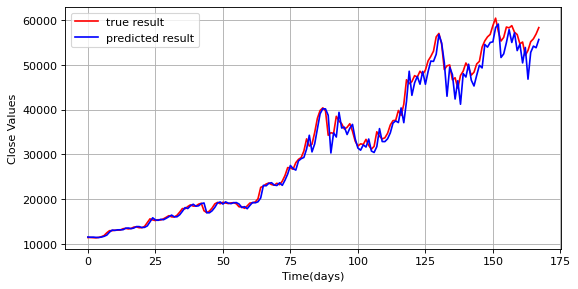

[0.93079995 0.93996371 0.97265175 1.         0.95123182 0.91536953
 0.92890455 0.96718482 0.96406547 0.97227405 0.94800384 0.93931175
 0.9048418  0.91179954 0.86213479 0.88065134 0.91294697 0.92352737
 0.94141005 0.92113197]
[0.93996371 0.97265175 1.         0.95123182 0.91536953 0.92890455
 0.96718482 0.96406547 0.97227405 0.94800384 0.93931175 0.9048418
 0.91179954 0.86213479 0.88065134 0.91294697 0.92352737 0.94141005
 0.92113197 0.86018598]
[0.97265175 1.         0.95123182 0.91536953 0.92890455 0.96718482
 0.96406547 0.97227405 0.94800384 0.93931175 0.9048418  0.91179954
 0.86213479 0.88065134 0.91294697 0.92352737 0.94141005 0.92113197
 0.86018598 0.78042537]
[1.         0.95123182 0.91536953 0.92890455 0.96718482 0.96406547
 0.97227405 0.94800384 0.93931175 0.9048418  0.91179954 0.86213479
 0.88065134 0.91294697 0.92352737 0.94141005 0.92113197 0.86018598
 0.78042537 0.70090365]
[0.95123182 0.91536953 0.92890455 0.96718482 0.96406547 0.97227405
 0.94800384 0.93931175 0.9048418  

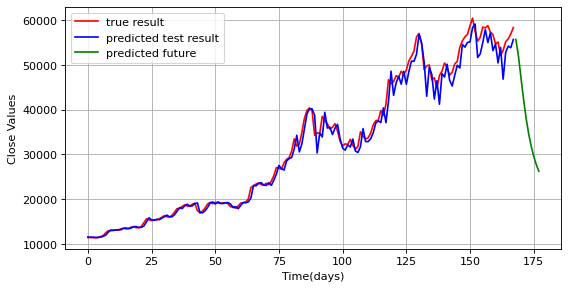

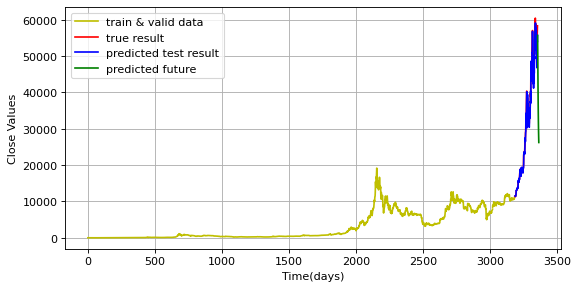

In [ ]:
main(20, 'lstm1', model_path = "/content/drive/MyDrive/RNN/lstm1/20",
         history_path = "/content/drive/MyDrive/RNN/lstm1/20/history.npy", price_by_date = price_by_date)

LSTM 1 30

(3010, 30, 1) (3010, 1, 1)
(335, 30, 1) (335, 1, 1)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, None, 128)         66560     
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
95/95 [==============================] - 8s 68ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 8.7872e-05 - val_mse: 8.7872e-05
Epoch 2/100
95/95 [==============================] - 6s 64ms/step - loss: 8.9923e-05 - mse: 8.9923e-05 - val_loss: 2.2917e-04 - val_mse: 2.2917e-04
Epoch 3/100
95/95 [===================

INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN/lstm1/30/assets


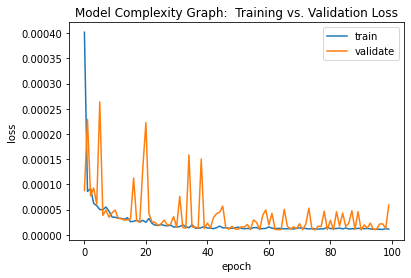

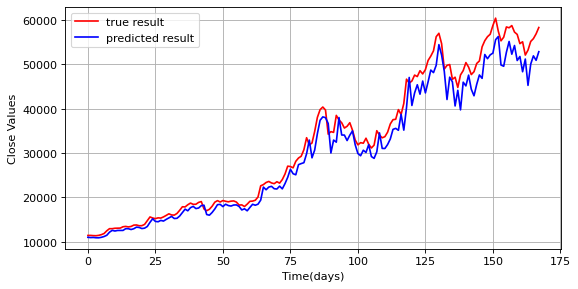

[0.78802337 0.80416445 0.83414152 0.81708325 0.78928234 0.80009928
 0.83064728 0.84024402 0.8928894  0.91595779 0.93079995 0.93996371
 0.97265175 1.         0.95123182 0.91536953 0.92890455 0.96718482
 0.96406547 0.97227405 0.94800384 0.93931175 0.9048418  0.91179954
 0.86213479 0.88065134 0.91294697 0.92352737 0.94141005 0.87476128]
[0.80416445 0.83414152 0.81708325 0.78928234 0.80009928 0.83064728
 0.84024402 0.8928894  0.91595779 0.93079995 0.93996371 0.97265175
 1.         0.95123182 0.91536953 0.92890455 0.96718482 0.96406547
 0.97227405 0.94800384 0.93931175 0.9048418  0.91179954 0.86213479
 0.88065134 0.91294697 0.92352737 0.94141005 0.87476128 0.74929929]
[0.83414152 0.81708325 0.78928234 0.80009928 0.83064728 0.84024402
 0.8928894  0.91595779 0.93079995 0.93996371 0.97265175 1.
 0.95123182 0.91536953 0.92890455 0.96718482 0.96406547 0.97227405
 0.94800384 0.93931175 0.9048418  0.91179954 0.86213479 0.88065134
 0.91294697 0.92352737 0.94141005 0.87476128 0.74929929 0.62762761]


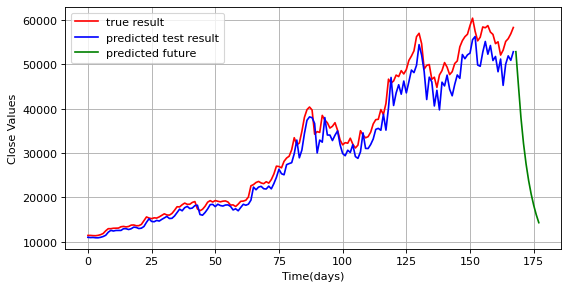

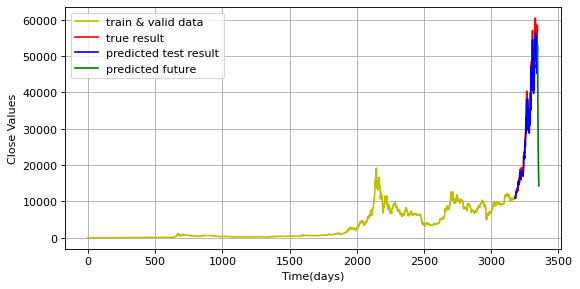

In [ ]:
main(30, 'lstm1', model_path = "/content/drive/MyDrive/RNN/lstm1/30",
         history_path = "/content/drive/MyDrive/RNN/lstm1/30/history.npy", price_by_date = price_by_date)

LSTM1 50

(2992, 50, 1) (2992, 1, 1)
(333, 50, 1) (333, 1, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 128)         66560     
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 12s 103ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 1.3481e-04 - val_mse: 1.3481e-04
Epoch 2/100
94/94 [==============================] - 9s 100ms/step - loss: 1.2367e-04 - mse: 1.2367e-04 - val_loss: 6.8873e-05 - val_mse: 6.8873e-05
Epoch 3/100
94/94 [================

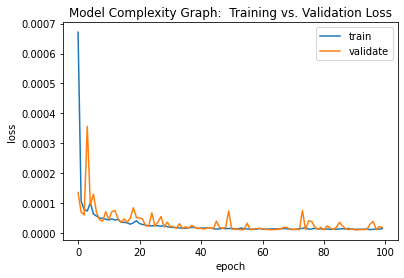

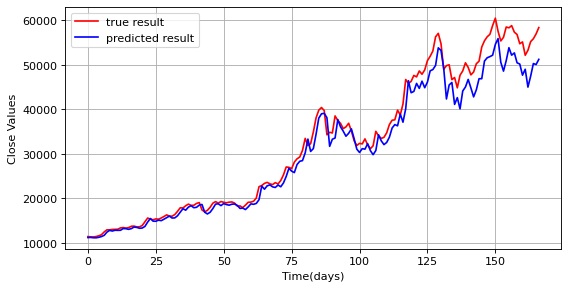

[0.77219174 0.75753938 0.76537181 0.78739276 0.78194103 0.80388657
 0.7916769  0.80793402 0.8421558  0.858357   0.87805159 0.9307783
 0.94350813 0.90492326 0.80997983 0.82373378 0.82679325 0.77171912
 0.77956488 0.74132331 0.78802337 0.80416445 0.83414152 0.81708325
 0.78928234 0.80009928 0.83064728 0.84024402 0.8928894  0.91595779
 0.93079995 0.93996371 0.97265175 1.         0.95123182 0.91536953
 0.92890455 0.96718482 0.96406547 0.97227405 0.94800384 0.93931175
 0.9048418  0.91179954 0.86213479 0.88065134 0.91294697 0.92352737
 0.94141005 0.84704357]
[0.75753938 0.76537181 0.78739276 0.78194103 0.80388657 0.7916769
 0.80793402 0.8421558  0.858357   0.87805159 0.9307783  0.94350813
 0.90492326 0.80997983 0.82373378 0.82679325 0.77171912 0.77956488
 0.74132331 0.78802337 0.80416445 0.83414152 0.81708325 0.78928234
 0.80009928 0.83064728 0.84024402 0.8928894  0.91595779 0.93079995
 0.93996371 0.97265175 1.         0.95123182 0.91536953 0.92890455
 0.96718482 0.96406547 0.97227405 0.9480

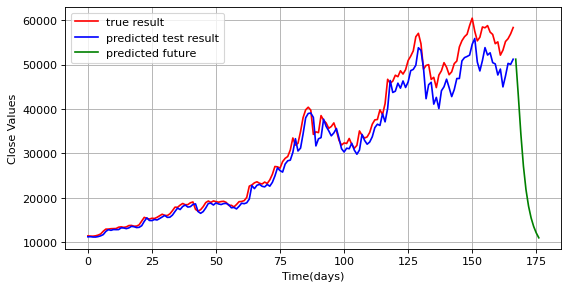

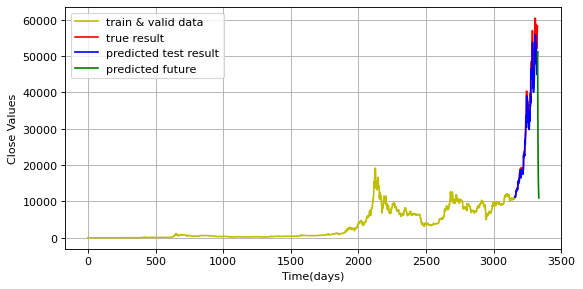

In [ ]:
main(50, 'lstm1', model_path = "/content/drive/MyDrive/RNN/lstm1/50",
         history_path = "/content/drive/MyDrive/RNN/lstm1/50/history.npy", price_by_date = price_by_date)

lstm2 20

(3019, 20, 1) (3019, 1, 1)
(336, 20, 1) (336, 1, 1)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 200)               161600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 162,601
Trainable params: 162,201
Non-trainable params: 400
_________________________________________________________________
Epoch 1/100
95/95 [==============================] - 6s 47ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 2/100
95/95 [==============================] - 4s 42ms

INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN/lstm2/20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN/lstm2/20/assets


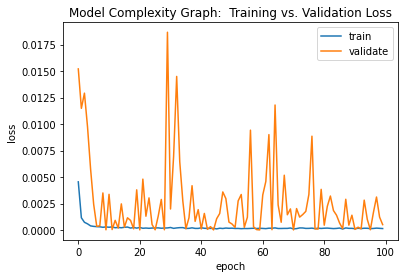

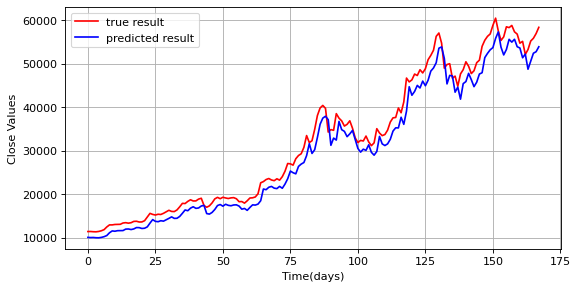

[0.93079995 0.93996371 0.97265175 1.         0.95123182 0.91536953
 0.92890455 0.96718482 0.96406547 0.97227405 0.94800384 0.93931175
 0.9048418  0.91179954 0.86213479 0.88065134 0.91294697 0.92352737
 0.94141005 0.8911944 ]
[0.93996371 0.97265175 1.         0.95123182 0.91536953 0.92890455
 0.96718482 0.96406547 0.97227405 0.94800384 0.93931175 0.9048418
 0.91179954 0.86213479 0.88065134 0.91294697 0.92352737 0.94141005
 0.8911944  0.83255965]
[0.97265175 1.         0.95123182 0.91536953 0.92890455 0.96718482
 0.96406547 0.97227405 0.94800384 0.93931175 0.9048418  0.91179954
 0.86213479 0.88065134 0.91294697 0.92352737 0.94141005 0.8911944
 0.83255965 0.7777282 ]
[1.         0.95123182 0.91536953 0.92890455 0.96718482 0.96406547
 0.97227405 0.94800384 0.93931175 0.9048418  0.91179954 0.86213479
 0.88065134 0.91294697 0.92352737 0.94141005 0.8911944  0.83255965
 0.7777282  0.726686  ]
[0.95123182 0.91536953 0.92890455 0.96718482 0.96406547 0.97227405
 0.94800384 0.93931175 0.9048418  0

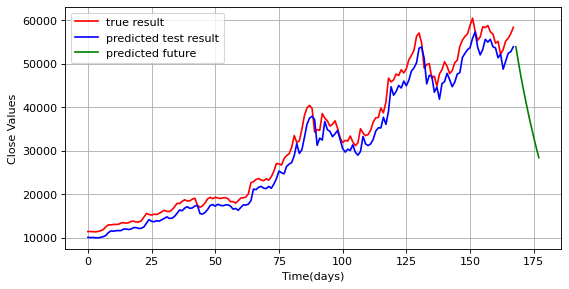

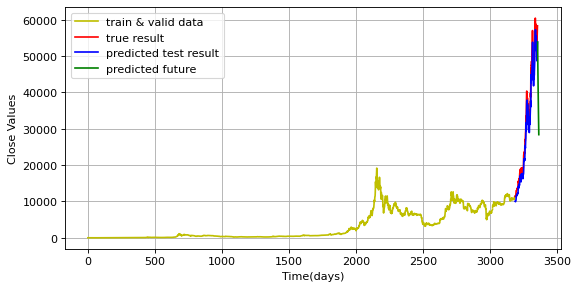

In [ ]:
main(20, 'lstm2', model_path = "/content/drive/MyDrive/RNN/lstm2/20",
         history_path = "/content/drive/MyDrive/RNN/lstm2/20/history.npy", price_by_date = price_by_date)

lstm2 30

(3010, 30, 1) (3010, 1, 1)
(335, 30, 1) (335, 1, 1)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 200)               161600    
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 201       
Total params: 162,601
Trainable params: 162,201
Non-trainable params: 400
_________________________________________________________________
Epoch 1/100
95/95 [==============================] - 8s 64ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 2/100
95/95 [==============================] - 6s 59ms

INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN/lstm2/30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN/lstm2/30/assets


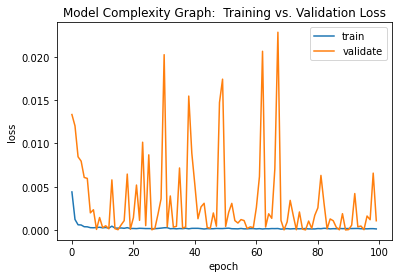

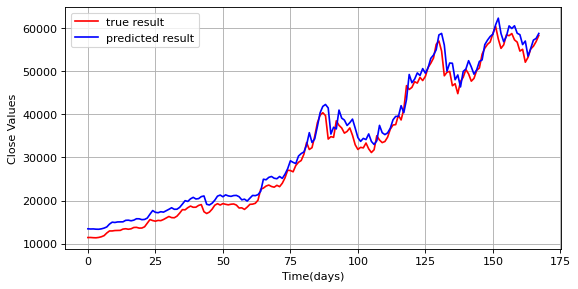

[0.78802337 0.80416445 0.83414152 0.81708325 0.78928234 0.80009928
 0.83064728 0.84024402 0.8928894  0.91595779 0.93079995 0.93996371
 0.97265175 1.         0.95123182 0.91536953 0.92890455 0.96718482
 0.96406547 0.97227405 0.94800384 0.93931175 0.9048418  0.91179954
 0.86213479 0.88065134 0.91294697 0.92352737 0.94141005 0.97266293]
[0.80416445 0.83414152 0.81708325 0.78928234 0.80009928 0.83064728
 0.84024402 0.8928894  0.91595779 0.93079995 0.93996371 0.97265175
 1.         0.95123182 0.91536953 0.92890455 0.96718482 0.96406547
 0.97227405 0.94800384 0.93931175 0.9048418  0.91179954 0.86213479
 0.88065134 0.91294697 0.92352737 0.94141005 0.97266293 1.0053364 ]
[0.83414152 0.81708325 0.78928234 0.80009928 0.83064728 0.84024402
 0.8928894  0.91595779 0.93079995 0.93996371 0.97265175 1.
 0.95123182 0.91536953 0.92890455 0.96718482 0.96406547 0.97227405
 0.94800384 0.93931175 0.9048418  0.91179954 0.86213479 0.88065134
 0.91294697 0.92352737 0.94141005 0.97266293 1.0053364  1.03738737]


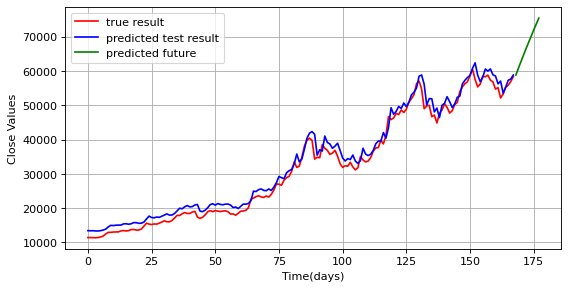

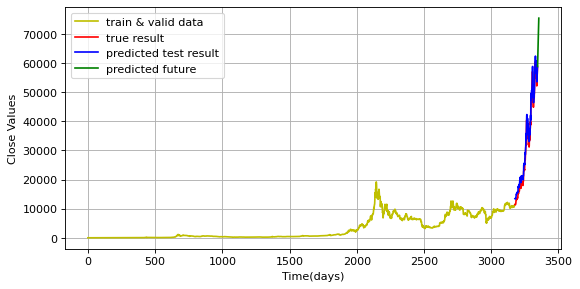

In [ ]:
main(30, 'lstm2', model_path = "/content/drive/MyDrive/RNN/lstm2/30",
         history_path = "/content/drive/MyDrive/RNN/lstm2/30/history.npy", price_by_date = price_by_date)

lstm2 50

(2992, 50, 1) (2992, 1, 1)
(333, 50, 1) (333, 1, 1)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 200)               161600    
_________________________________________________________________
batch_normalization_3 (Batch (None, 200)               800       
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 162,601
Trainable params: 162,201
Non-trainable params: 400
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 11s 98ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 2/100
94/94 [==============================] - 8s 90m

INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN/lstm2/50/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN/lstm2/50/assets


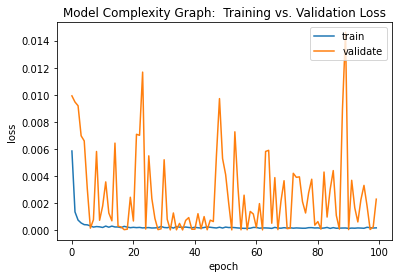

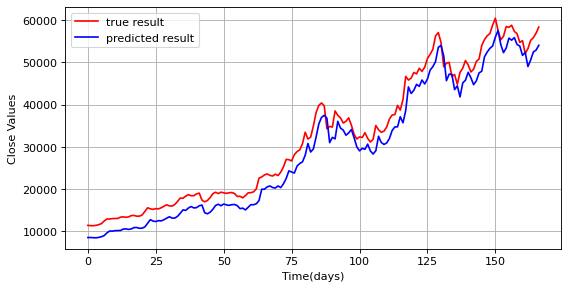

[0.77219174 0.75753938 0.76537181 0.78739276 0.78194103 0.80388657
 0.7916769  0.80793402 0.8421558  0.858357   0.87805159 0.9307783
 0.94350813 0.90492326 0.80997983 0.82373378 0.82679325 0.77171912
 0.77956488 0.74132331 0.78802337 0.80416445 0.83414152 0.81708325
 0.78928234 0.80009928 0.83064728 0.84024402 0.8928894  0.91595779
 0.93079995 0.93996371 0.97265175 1.         0.95123182 0.91536953
 0.92890455 0.96718482 0.96406547 0.97227405 0.94800384 0.93931175
 0.9048418  0.91179954 0.86213479 0.88065134 0.91294697 0.92352737
 0.94141005 0.8936947 ]
[0.75753938 0.76537181 0.78739276 0.78194103 0.80388657 0.7916769
 0.80793402 0.8421558  0.858357   0.87805159 0.9307783  0.94350813
 0.90492326 0.80997983 0.82373378 0.82679325 0.77171912 0.77956488
 0.74132331 0.78802337 0.80416445 0.83414152 0.81708325 0.78928234
 0.80009928 0.83064728 0.84024402 0.8928894  0.91595779 0.93079995
 0.93996371 0.97265175 1.         0.95123182 0.91536953 0.92890455
 0.96718482 0.96406547 0.97227405 0.9480

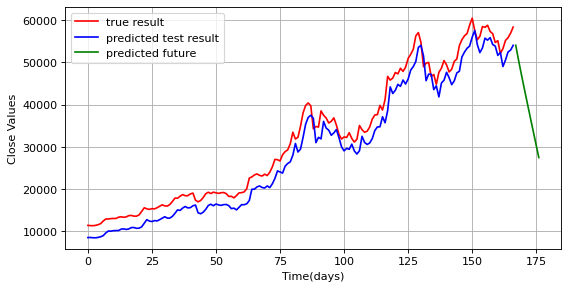

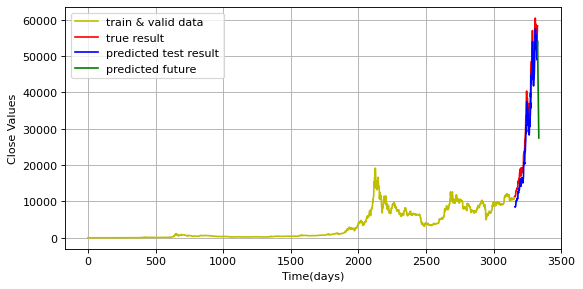

In [ ]:
main(50, 'lstm2', model_path = "/content/drive/MyDrive/RNN/lstm2/50",
         history_path = "/content/drive/MyDrive/RNN/lstm2/50/history.npy", price_by_date = price_by_date)

Create an overview of 10 days bitcoin-USD-price

(3019, 20, 1) (3019, 1, 1)
(336, 20, 1) (336, 1, 1)
(3010, 30, 1) (3010, 1, 1)
(335, 30, 1) (335, 1, 1)
(2992, 50, 1) (2992, 1, 1)
(333, 50, 1) (333, 1, 1)
(3019, 20, 1) (3019, 1, 1)
(336, 20, 1) (336, 1, 1)
(3010, 30, 1) (3010, 1, 1)
(335, 30, 1) (335, 1, 1)
(2992, 50, 1) (2992, 1, 1)
(333, 50, 1) (333, 1, 1)
(3019, 20, 1) (3019, 1, 1)
(336, 20, 1) (336, 1, 1)
(3010, 30, 1) (3010, 1, 1)
(335, 30, 1) (335, 1, 1)
(2992, 50, 1) (2992, 1, 1)
(333, 50, 1) (333, 1, 1)
(3019, 20, 1) (3019, 1, 1)
(336, 20, 1) (336, 1, 1)
(3010, 30, 1) (3010, 1, 1)
(335, 30, 1) (335, 1, 1)
(2992, 50, 1) (2992, 1, 1)
(333, 50, 1) (333, 1, 1)


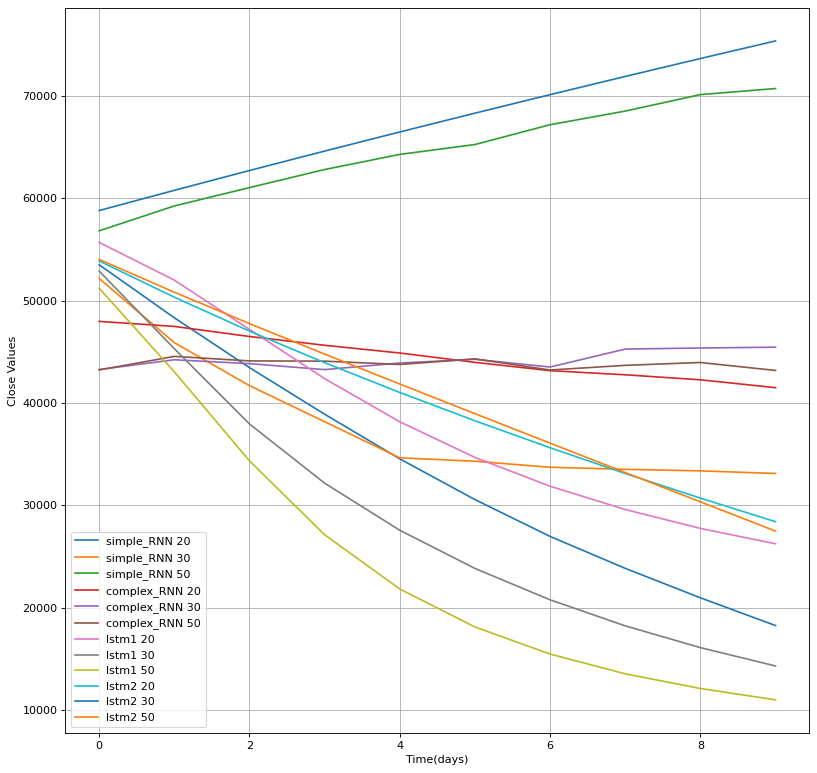

In [ ]:
model_names = ['simple_RNN', 'complex_RNN', 'lstm1', 'lstm2']
time_windows = ['20','30','50']
int_time = [20, 30, 50]
pred = []

prediction = np.array(pred)
for i in range(4):

  for j in range(3):

    path = f"/content/drive/MyDrive/RNN/{model_names[i]}/{time_windows[j]}"
    model = keras.models.load_model(path)
    pred = []
    ## predict first 10 days that is influenced by last X_test data
    price_groups, scaler = create_data(int_time[j]+1,price_by_date=price_by_date)
    X_train, y_train, X_test, y_test = split_data(price_groups, 0.90)
    pr = model.predict(X_test[-1,:,:].reshape(1,int_time[j],1))
    t = np.array(X_test[-1,:,:])
    pred.append(pr)


    for k in range(1,10):
          t = np.delete(t,0)
          t = np.append(t,pr)
          # print(t)
          pr = model.predict(t.reshape(1,int_time[j],1))
          pred.append(pr)


    pred = np.array(pred).reshape(10,1)
    pred = scaler.inverse_transform(pred)
    prediction = np.append(prediction, pred)
   
# # # colors =['r','g','b','y','c','m','k',]
data_test = scaler.inverse_transform(y_test.reshape(len(y_test),1))
prediction = prediction.reshape(12, 10)
plt.figure(figsize=(12,12), dpi=80, facecolor='w', edgecolor='k')
for i in range(12):

  plt.plot(prediction[i].reshape(10),label= f"{model_names[int(i/3)]} {time_windows[i%3]}")

plt.legend()
plt.xlabel("Time(days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

  

MEAN PREDICTION

In [ ]:
sum_price = []
for i in range(10):
  sum_price.append(sum(prediction[:,i]))
  sum_price[i] = sum_price[i] /12
sum_price

[51953.568033854164,
 49332.195638020836,
 46465.175130208336,
 43984.60986328125,
 41906.83740234375,
 40397.377278645836,
 38968.56795247396,
 38089.933430989586,
 37218.65779622396,
 36244.586100260414]

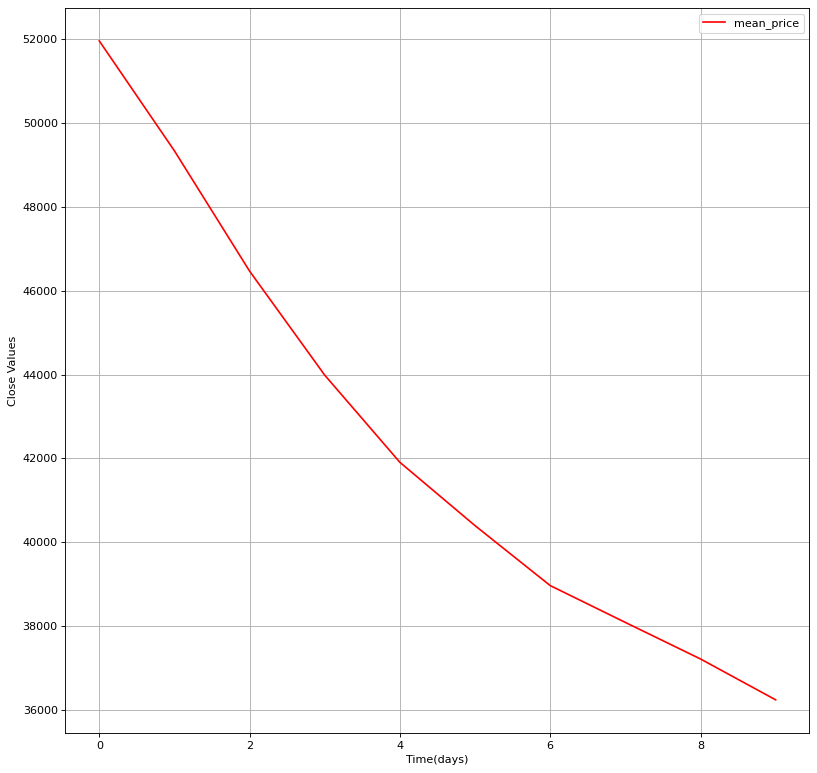

In [ ]:
prediction = prediction.reshape(12, 10)
plt.figure(figsize=(12,12), dpi=80, facecolor='w', edgecolor='k')

plt.plot(sum_price, label= 'mean_price', color = 'r')

plt.legend()
plt.xlabel("Time(days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()


PREDICTION BASED ON BEST FITTED MODELS

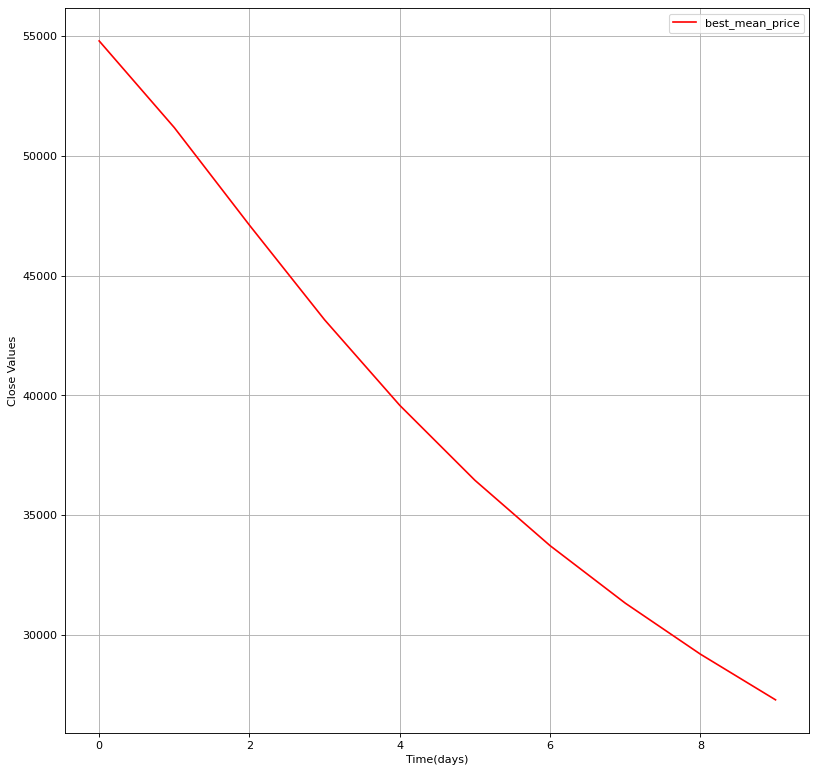

In [ ]:
best_sum = []
for i in range(10):
  best_sum.append(prediction[6,i]+prediction[9,i])
  best_sum[i] = best_sum[i] /2

plt.figure(figsize=(12,12), dpi=80, facecolor='w', edgecolor='k')

plt.plot(best_sum, label= 'best_mean_price', color = 'r')

plt.legend()
plt.xlabel("Time(days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()
